In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
# use seaborn plot styles
sns.set()

%matplotlib inline
# increase max columns so we can see everything.
# Jupyter is nice in that it puts the table into a scrolling window
pd.set_option('display.max_columns', None)
pd.set_option('display.max_rows', 10)

# use this to hide the red warning boxes
# Only use once you know they aren't significant
import warnings
warnings.filterwarnings('ignore')

# Process phenotype data

Read the full phenotypes csv file, correct any inconsistencies in data entry for relevant fields, apply filters, and export ready to merge with the genetic data.

In [2]:
# load the data
try:
    df = pd.read_pickle('Processed_data/phenotypes_processed.pickle') #, header=0, index_col=0)
except FileNotFoundError:
    df = pd.read_csv('Data/DDD_Full_Data.csv', header=0, encoding = "ISO-8859-1")
    # These two columns contain identifiable data (of clinicians) that I don't particularly want stored online
    df = df.drop(['referring_clinician_name', 'referring_clinician_email'], axis=1)


    # Remove singleton samples (i.e no parental IDs)
    df = df[df.mother_stable_id != "-"]

    # Inspect each column for potential issues
    # pandas attempts to convert each column into an appropriate type when the CSV is read
    # "object" is a catch-all type. If a column isn't as expected (i.e. a numerical column isn't int/float)
    # it might indicate inapropriate values in the columnd that must be corrected
    df.mothers_age = pd.to_numeric(df.mothers_age, errors='coerce')
    df.consanguinity = df.consanguinity.astype('category')
    df.assisted_reproduction = df.assisted_reproduction.astype('category')
    df.pregnancy_loss_history = df.pregnancy_loss_history.astype('category')

    # Some of the values in the pregancy loss column are inconsistently named. Correct this.
    df.pregnancy_loss_history = df.pregnancy_loss_history.replace("3 or More", "3+")
    df.pregnancy_loss_history = df.pregnancy_loss_history.replace("3 or more", "3+")

    # Output the processed DataFrame to a CSV for use in the next notebook
    df.to_pickle('Processed_data/phenotypes_processed.pickle')

# Cut down the number of columns here to make it easier to choose things for plotting
cols_to_select = [
    'family_id',
    'proband_stable_id',
    'mother_stable_id',
    'father_stable_id',
    'mothers_age',
    'consanguinity',
    'birthweight',
    'assisted_reproduction', 
    'pregnancy_loss_history'
]
df_trimmed = df[cols_to_select]

## Basic data plots

These plots are to have a look at the data and check for any obvious inconsistencies or patterns

Maternal age should be within sensible limits (e.g. no obvious errors like "0" age mothers)

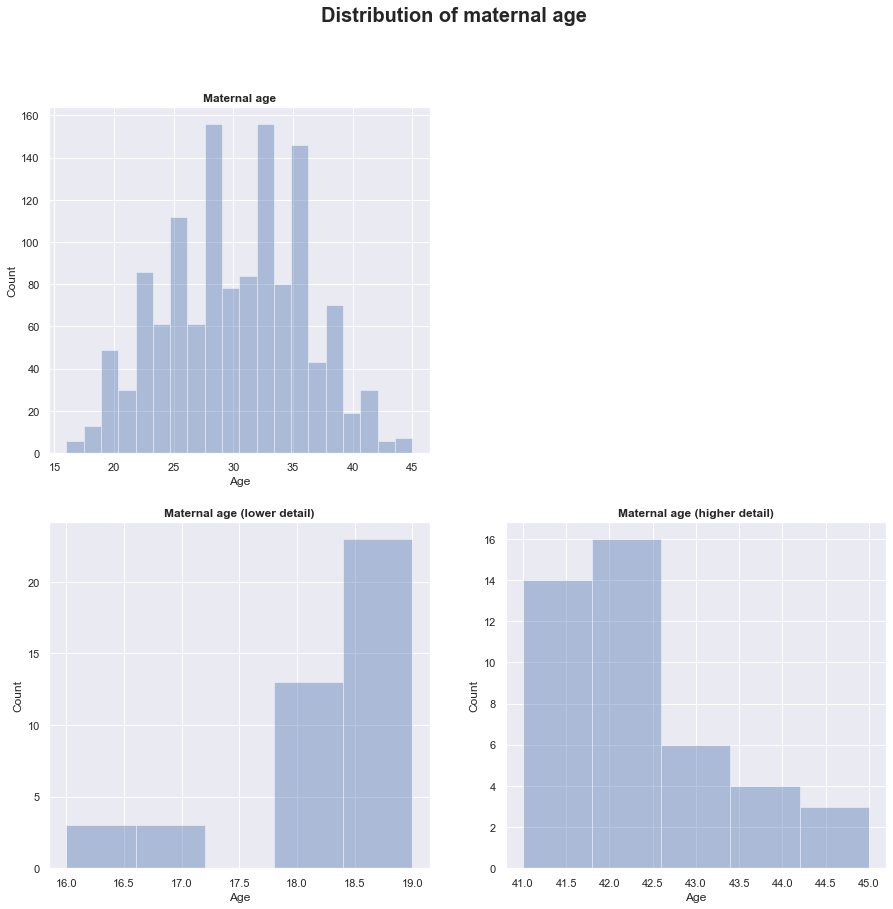

In [3]:
# mothers age is a continuous value
# obviously there should not be mothers of age zero, but we have one in this data. Correct it to n/a
df_trimmed.mothers_age = df_trimmed.mothers_age.replace(0, np.nan)

f, axes = plt.subplots(2, 2, figsize=(15, 14))
f.suptitle("Distribution of maternal age", fontweight='bold', fontsize=20)

ax = sns.distplot(df_trimmed.mothers_age.dropna(), ax=axes[0][0],kde=False, norm_hist=False, bins=20)
ax.set_title("Maternal age", fontweight='bold')
ax.set_ylabel("Count")
ax.set_xlabel("Age")

ax2 = sns.distplot(df_trimmed.mothers_age.dropna()[df_trimmed.mothers_age.dropna() < 20], ax=axes[1][0],kde=False, norm_hist=False, bins=5)
ax2.set_title("Maternal age (lower detail)", fontweight='bold')
ax2.set_ylabel("Count")
ax2.set_xlabel("Age")

ax3 = sns.distplot(df_trimmed.mothers_age.dropna()[df_trimmed.mothers_age.dropna() > 40], ax=axes[1][1],kde=False, norm_hist=False, bins=5)
ax3.set_title("Maternal age (higher detail)", fontweight='bold')
ax3.set_ylabel("Count")
ax3.set_xlabel("Age")

f.delaxes(axes[0,1])

# DEV: to hide plotting output
print("")

Birthweight may indicate some useful information about the cohort as a whole. The average European baby birth weight is ~3.5KG but varies slighly depending on ethnicity. (Jannsenn, 2007 PMID 20101298) Overall size will also affect the weight, so the dataset also includes the birthweight centile values which will account for this.
 * Birthweight vs. centile data is useful, as the weight appears to be distributed around the expeted value, but centile data shows there is actually an overrepresentation of low-birthweight babies in this datset. There is also a spike of very large babies.

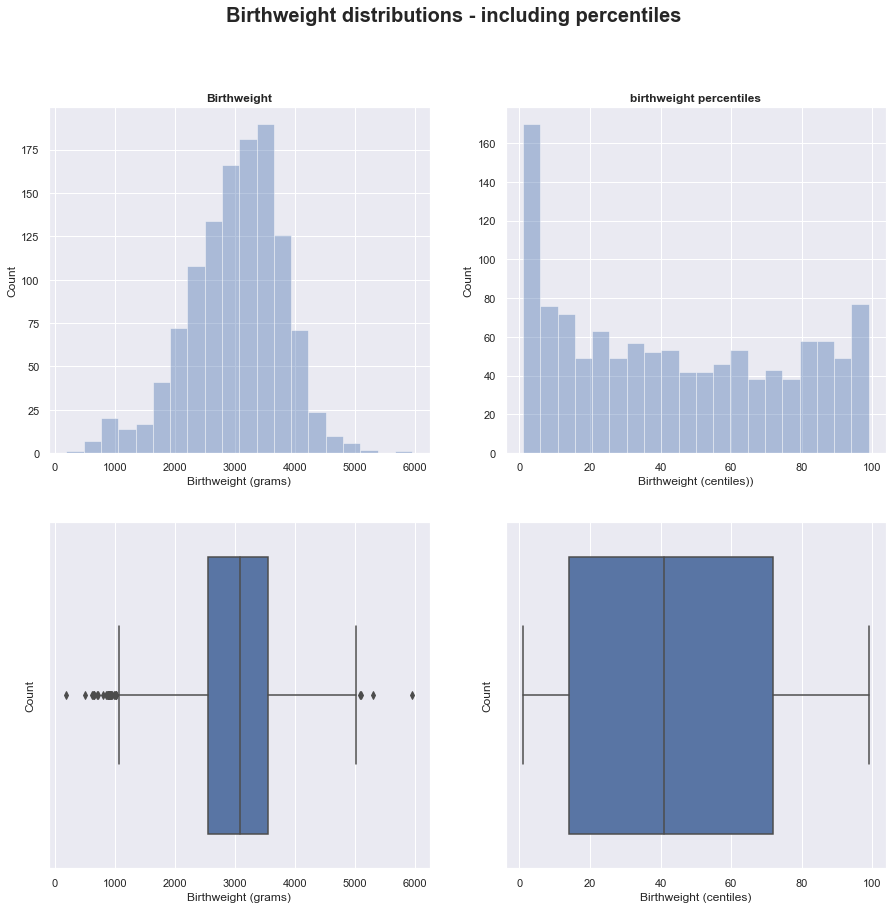

In [4]:
# Birthweight has some low values, but no zero values.
# There is a spike at 1000 that may represent guestimated data entry?
f, axes = plt.subplots(2, 2, figsize=(15, 14))
f.suptitle("Birthweight distributions - including percentiles", fontweight='bold', fontsize=20)

ax = sns.distplot(df_trimmed.birthweight.dropna(), ax=axes[0,0],kde=False, norm_hist=False, bins=20)
ax.set_title("Birthweight", fontweight='bold')
ax.set_ylabel("Count")
ax.set_xlabel("Birthweight (grams)")

ax2 = sns.distplot(df.birthweight_percentile.dropna()[df.birthweight_percentile.dropna() <=1000], ax=axes[0,1], kde=False, norm_hist=False, bins=20)
ax2.set_title("birthweight percentiles", fontweight='bold')
ax2.set_ylabel("Count")
ax2.set_xlabel("Birthweight (centiles))")

ax3 = sns.boxplot(x='birthweight', data=df, ax=axes[1,0])
ax3.set_ylabel("Count")
ax3.set_xlabel("Birthweight (grams)")

ax4 = sns.boxplot(x='birthweight_percentile', data=df, ax=axes[1,1])
ax4.set_ylabel("Count")
ax4.set_xlabel("Birthweight (centiles)")

# DEV: to hide plotting output
print("")

**NOTE:** There are some very low birthweights! Are these sensible for liveborn (presumably surviving) babies? Are there other categories that might help to explain them? Does it even matter, since we're more interested in the mother at this point? There's a spike at 1000 - is this just a round number 'guestimate' type thing?

Birthweight is almost certainly linked to weeks of gestation. Quickly do a plot of that.

**NOTE:** Despite what the scale shows, the lowest recorded gestation in the dataset it 23 weeks. 16 is an artefact of the scaling used by the plot library.

What does the pattern of pregnancy loss look like within this data?

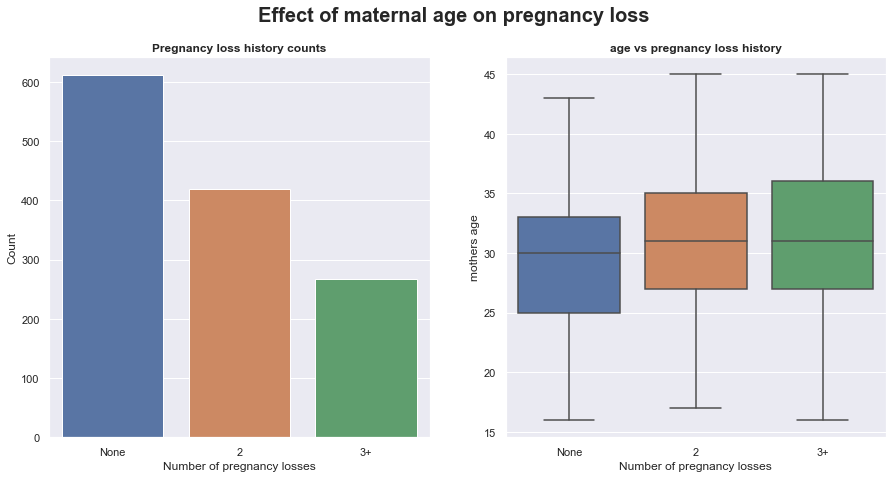

In [5]:
f, axes = plt.subplots(1, 2, figsize=(15,7))
f.suptitle("Effect of maternal age on pregnancy loss", fontweight='bold', fontsize=20)

ax = sns.countplot(x='pregnancy_loss_history',data=df_trimmed, order=['None', '2', '3+'], ax=axes[0]) 
ax.set_title("Pregnancy loss history counts", fontweight='bold')
ax.set_ylabel("Count")
ax.set_xlabel("Number of pregnancy losses")

ax2 = sns.boxplot(x='pregnancy_loss_history', y='mothers_age', data=df_trimmed, order=['None', '2', '3+'], ax=axes[1])
ax2.set_title("age vs pregnancy loss history", fontweight='bold')
ax2.set_ylabel("mothers age")
ax2.set_xlabel("Number of pregnancy losses")

# DEV: to hide plotting output
print("")

Age appears to be a minor factor, but this does not seem significantly different and is actually to be expected - older mothers will simply have had more time for multiple pregnancy losses to occur. Since younger people would only be present if they have an affected child, we are missing out on the women with recurrent losses who have not had a child (whether due to age or total lack of fertility).

<AxesSubplot:xlabel='mothers_age'>

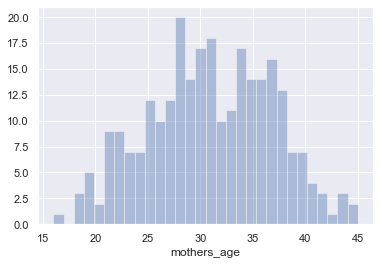

In [6]:
sns.distplot(df_trimmed[df_trimmed.pregnancy_loss_history == '3+'].mothers_age, bins=30, kde=False, norm_hist=False)